# Descripcion del proyecto

 **¿Cuál es un mejor plan?**

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

**Objetivo**

Saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

**Descripción de las tarifas**

Nota: Megaline redondea los segundos a minutos y los megabytes a gigabytes. Para **llamadas**, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. Para **tráfico web**, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.

| Detalle         | **Surf** | **Ultimate** |
|-----------------|----------|----------    |
| Pago mensual    | 20 USD   | 70 USD       |
| Paquete         | 500 minutos al mes, 50 SMS y 15 GB de datos   | 3000 minutos al mes, 1000 SMS y 30 GB de datos  |
| Límite excedido | - 1 minuto: 3 centavos | - 1 minuto: 1 centavo |
|                 | - 1 SMS: 3 centavos    | - 1 SMS: 1 centavo|
|                 | - 1 GB de datos: 10 USD| - 1 GB de datos: 7 USD  |

### Tabla `users`
Almacena los datos de los usuarios:
- *user_id* — identificador único del usuario
- *first_name* — nombre del usuario
- *last_name* — apellido del usuario
- *age* — edad del usuario (en años)
- *reg_date* — fecha de suscripción (dd, mm, aa)
- *churn_date* — la fecha en que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando se recuperaron estos datos)
- *city* — ciudad de residencia del usuario
- *plan* — nombre de la tarifa

### Tabla `calls`
Almacena los datos sobre las llamadas:

- *id* — identificador único de la llamada
- *call_date* — fecha de la llamada
- *duration* — duración de la llamada (en minutos) - **Estos se redondean hacia minutos, 1 seg = 1 min**.
- *user_id* — el identificador del usuario que realiza la llamada

### Tabla `messages`
Almacena los datos sobre los SMS:

- *id* — identificador único del SMS
- *message_date* — fecha del SMS
- *user_id* — el identificador del usuario que manda el SMS

### Tabla `internet`
Almacena los datos sobre las sesiones web:

- *id* — identificador único de la sesión
- *mb_used* — el volumen de datos gastados durante la sesión (en megabytes)
- *session_date* — fecha de la sesión web
- *user_id* — identificador del usuario

### Tabla `plans`
Almacena los datos sobre las tarifas:

- *plan_name* — nombre de la tarifa
- *usd_monthly_fee* — pago mensual en dólares estadounidenses
- *minutes_included* — minutos incluidos al mes
- *messages_included* — SMS incluidos al mes
- *mb_per_month_included* — datos incluidos al mes (en megabytes) - **Estos se redondean hacia arriba**.
- *usd_per_minute* — precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos el operador cobrará el minuto 101)
- *usd_per_message* — precio por SMS tras exceder los límites del paquete
- *usd_per_gb* — precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes)

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

## Cargar los datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_plans = pd.read_csv('/datasets/megaline_plans.csv')
df_users = pd.read_csv('/datasets/megaline_users.csv')

# Preparar los datos

Los datos para este proyecto se dividen en muchas tablas por lo que, exploraremos cada una para tener una comprensión inicial de los datos.

## Planes

In [3]:
# Imprime la información general/resumen sobre el DataFrame de los planes
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para los planes
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


En esta tabla se observa el detalle correspondiente a los 2 planes de Megaline: Surf y Ultimate. No se observan valores nulos ni problemas con los tipos de datos por lo que, no habrían correcciones que realizar.

## Usuarios

In [5]:
# Imprime la información general/resumen sobre el DataFrame de los usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
# Imprime una muestra de los datos para los usuarios
df_users.loc[df_users['churn_date'].isnull()]
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


En esta tabla se observa lo siguiente:
1. Las columnas `reg_date` y `churn_date` almacenan fechas por lo que el tipo de dato debe ser datetime. En ese sentido, se corregira al tipo de dato 
correspondiente.
2. En la columna `churn_date` se observan 466 valores nulos, sin embargo, esto significa que al momento de extraer los datos, aun el servicio se encontraba activo. Por lo tanto, para no tener valores nulos, crearemos 2 nuevas columnas a la tabla:
- `status_plan`: Esta columna tendra el estado del plan como 0 y 1 el cual indicara inactivo o activo, correspondientemente.
- `subscription_days`: Esta columna tendra el calculo de dias con el plan activo. Restaremos `churn_date` con `reg_date` y en caso de las filas NaN, se restara con el ultimo dia de 2018.

### Corregir datos

En primer lugar, corregimos el tipo de dato de `reg_date`.

In [7]:
#Corregimos el tipo de dato de `reg_date` a tipo datetime
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

In [8]:
#Validamos el tipo de dato
df_users.dtypes['reg_date']

dtype('<M8[ns]')

A continuacion, corregimos el tipo de dato de `churn_date` ignorando los valores ausentes.

In [9]:
#Corregimos el tipo de dato de `churn_date` a tipo datetime ignorando los valores nulos
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d',errors='ignore')

In [10]:
#Validamos el tipo de dato
df_users.dtypes['churn_date']

dtype('<M8[ns]')

### Enriquecer datos

Creamos la funcion `get_status_plan` que complete los valores de la nueva columna `status_plan` con 1 para las filas que tienen la columna `churn_date` como Nat y 0 para los que no.

In [11]:
#Creamos la funcion get_status_plan

def get_status_plan(row):
    if pd.isna(row) == True:
        return 1
    else:
        return 0

#Creamos y llenamos la nueva columna `status_plan` aplicando la funcion.
df_users['status_plan'] = df_users['churn_date'].apply(get_status_plan)

In [12]:
#Creamos y completamos la nueva columna `subscription_days` con la diferencia de fechas de `churn_date` y `reg_date`.
df_users['subscription_days'] = df_users['churn_date'] - df_users['reg_date']

In [13]:
#Creamos la variable `end_year` y lo convertimos en tipo datetime para restarlo con las fechas de `reg_date` 
#y asi completar todos los valores nulos en `subscription_days`.
end_year = '2018-12-31'
end_year = pd.to_datetime(end_year, format='%Y-%m-%d')
df_users['subscription_days'] = df_users['subscription_days'].fillna(end_year - df_users['reg_date'])

Para enriquecer aun mas los datos, crearemos una columna nueva que almacenen los valores del mes de la fecha de suscripcion.

In [14]:
#Creamos y completamos 1 columna del mes
df_users['month_reg_date'] = df_users['reg_date'].dt.month

In [15]:
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,status_plan,subscription_days,month_reg_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,1,7 days,12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1,140 days,8
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,1,71 days,10
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,1,337 days,1
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,1,222 days,5


## Llamadas

In [16]:
# Imprime la información/resumen general sobre el DataFrame de las llamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [17]:
# Imprime una muestra de datos para llamadas
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


En la tabla de llamadas no se observan valores ausentes, pero si se sugiere corregir el tipo de dato de la columna `call_date` al tipo datetime.
Por otro lado, segun la documentacion dada, la columna `duration` se encuentra en minutos y segun lo especificado, esta debe redondearse hacia arriba, con lo que tendriamos minutos completos sin segundos.

### Corregir datos

In [18]:
#Corregimos el tipo de dato de `call_date` a tipo datetime
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

In [19]:
#Validamos el tipo de dato
df_calls.dtypes['call_date']

dtype('<M8[ns]')

### Enriquecer datos

Crearemos una columna nueva que almacenen los valores del mes de la fecha de llamada.

In [20]:
#Creamos y completamos 1 columna del mes
df_calls['month_call_date'] = df_calls['call_date'].dt.month

Dado que, 1 segundo se redondea a 1 minuto, redondearemos todos los valores de la columna `duration` que tienen decimales a minutos completos, de esta manera, no tendremos mas segundos.

In [21]:
#Mostramos los valores que son mayores a 0.1 minuto.
df_calls['duration'].loc[df_calls['duration'] > 0.1]

0          8.52
1         13.66
2         14.48
3          5.76
4          4.22
          ...  
137730     8.72
137731    10.89
137732     8.12
137733     0.37
137734    13.86
Name: duration, Length: 110370, dtype: float64

In [22]:
#Redondeamos hacia arriba los minutos con segundos a minutos completos.
df_calls['duration'] = np.ceil(df_calls.duration)
df_calls.head()

,id,user_id,call_date,duration,month_call_date
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12


A continuacion, revisamos los datos de la columna `duration` para examinar si existen valores atipicos.

In [23]:
#Validamos si existen llamadas con 0.0 minutos de duracion
100* df_calls['duration'][df_calls['duration'] == 0].count() / df_calls.shape[0]

19.48233927469416

Se observa que casi el 22% de los datos, tienen 0 minutos como duracion, estos podrian interpretarse como llamadas perdidas.  Revisamos su distribucion para ver que se puede hacer con estos datos.

In [24]:
#Mostramos la distribucion
df_calls['duration'].describe()

count    137735.000000
mean          7.146673
std           5.953919
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

Creamos un dataframe sin valores cero en la columna `duration` y mostramos la distribucion de esta.

In [25]:
#Creamos el nuevo dataframe y mostramos la distribucion
df_calls_clear = df_calls.loc[df_calls['duration'] > 0]
print (df_calls_clear['duration'].describe())

count    110901.000000
mean          8.875907
std           5.355181
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          38.000000
Name: duration, dtype: float64


Se observa que el promedio de la data se veria alterada si se eliminan los valores con 0 minutos. Por lo pronto, dejaremos estos valores tal como estan ya que, no impacta con el objetivo del proyecto.

## Mensajes

In [26]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [27]:
# Imprime una muestra de datos para los mensajes
df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


En la tabla de mensaje no se observan valores ausentes, solo se sugiere corregir el tipo de dato de la columna message_date al tipo datetime y extraer los valores de mes y año en 2 nuevas columnas.

### Corregir datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [28]:
#Corregimos el tipo de dato de `message_date` a tipo datetime
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')

In [29]:
#Validamos el tipo de dato
df_messages.dtypes['message_date']

dtype('<M8[ns]')

### Enriquecer datos

Crearemos una columna nueva que almacene los valores del mes de la fecha del mensaje.

In [30]:
#Creamos y completamos la columnas de mes
df_messages['month_message_date'] = df_messages['message_date'].dt.month

In [31]:
df_messages.head()

,id,user_id,message_date,month_message_date
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


## Internet

In [32]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [33]:
# Imprime una muestra de datos para el tráfico de internet
df_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


En la tabla de Internet no se observan valores ausentes, solo se sugiere corregir el tipo de dato de la columna session_date al tipo datetime y extraer los valores de mes y año en 2 nuevas columnas.

### Corregir datos

In [34]:
#Corregimos el tipo de dato de `message_date` a tipo datetime
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')

In [35]:
#Validamos el tipo de dato
df_internet.dtypes['session_date']

dtype('<M8[ns]')

### Enriquecer datos

Crearemos una columna nueva que almacene los valores del mes de la fecha de sesion.

In [36]:
#Creamos y completamos la columna de mes
df_internet['month_session_date'] = df_internet['session_date'].dt.month

In [37]:
df_internet.head()

,id,user_id,session_date,mb_used,month_session_date
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


# Estudiar las condiciones del plan

Imprimimos nuevamente el detalle de cada plan.

In [38]:
# Imprime las condiciones del plan y asegúrate de que te resulten claros
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


# Agregar datos por usuario

A continuacion, veremos el detalle de consumo del plan de cada usuario en su respectivo periodo, para ello, agruparemos cada tabla por codigo de usuario (`user_id`) y mes (`month`) para despues, unificarlo en un nuevo dataframe que tenga todo el resumen de consumo.

## Agrupamiento mensual de llamadas

Agrupamos el total de llamadas por usuario en cada mes y lo guardamos en una nueva tabla llamada `monthly_total_calls`.

In [39]:
# Calcula el número de llamadas hechas por cada usuario por mes, la cantidad de minutos que usó cada usuario por mes 
#y el promedio de minutos que uso cada usuario por mes. Guarda el resultado.

#monthly_total_calls = df_calls.groupby(['user_id','month_call_date'])['id'].count().reset_index()
#Renombramos la columna 'id' y 'month_call_date'.
#monthly_total_calls.rename(columns={"id": "total_calls", "month_call_date":"month"}, inplace=True)
#monthly_total_calls.head()

Agrupamos el total de minutos usados por usuario en cada mes y lo guardamos en una nueva tabla llamada `monthly_calls_min`.

In [40]:
# Calcula la cantidad de minutos que usó cada usuario por mes. Guarda el resultado.
#monthly_calls_min = df_calls.groupby(['user_id','month_call_date'])['duration'].sum().reset_index()
#Renombramos la columna 'month_call_date'.
#monthly_calls_min.rename(columns={"month_call_date":"month"}, inplace=True)
#monthly_calls_min.head()

In [41]:
# Calcula el número de llamadas hechas por cada usuario por mes, la cantidad de minutos que usó cada usuario por mes 
#y el promedio de minutos que uso cada usuario por mes. Guarda el resultado.
monthly_calls = df_calls.groupby(['user_id','month_call_date']).agg(['sum', 'mean','count']).reset_index()
#Renombramos las columnas para deshacernos de lol multiindex
monthly_calls.columns = ['user_id','month','total_minutes','mean_minutes','total_calls']

monthly_calls.head()

,user_id,month,total_minutes,mean_minutes,total_calls
0,1000,12,124.0,7.750000,16
1,1001,8,182.0,6.740741,27
2,1001,9,315.0,6.428571,49
3,1001,10,393.0,6.046154,65
4,1001,11,426.0,6.656250,64


## Agrupamiento mensual de mensajes

Agrupamos el total de mensajes por usuario en cada mes y lo guardamos en una nueva tabla llamada `monthly_messages`.

In [42]:
# Calcula el número de mensajes enviados por cada usuario por mes. Guarda el resultado.
monthly_messages = df_messages.groupby(['user_id','month_message_date'])['id'].count().reset_index()
#Renombramos la columna 'id' y 'month_message_date'.
monthly_messages.rename(columns={'id': 'total_messages', "month_message_date":"month"}, inplace=True)
monthly_messages.head()

,user_id,month,total_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


## Agrupamiento mensual de trafico de internet

Agrupamos el total de megabytes consumidos por usuario en cada mes y lo guardamos en una nueva tabla llamada `monthly_internet`.

In [43]:
# Calcula el volumen del trafico de internet usado por cada usuario por mes. Guarda el resultado.
monthly_internet = df_internet.groupby(['user_id','month_session_date'])['mb_used'].sum().reset_index()
#Renombramos la columna 'month_session_date'.
monthly_internet.rename(columns={"month_session_date":"month"}, inplace=True)
monthly_internet.head()

,user_id,month,mb_used
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30


## Unificacion de tablas agrupadas

En un nuevo dataframe llamado `monthly_usage`, unimos todas las tablas agrupadas para asi, tener el resumen mensual del consumo de cada usuario.

In [44]:
# Combina los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes y Añade la información del plan
#monthly_usage = (
#    monthly_total_calls
#    .merge(monthly_calls_min, on=["user_id", "month"], how="outer")
#    .merge(monthly_messages, on=["user_id", "month"], how="outer")
#    .merge(monthly_internet, on=["user_id", "month"], how="outer")
#    .merge(df_users.rename(columns={"plan": "plan_name"}), on="user_id", how="inner")
#    .merge(df_plans, on="plan_name")
#)

In [45]:
# Combina los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes y Añade la información del plan
monthly_usage = (
    monthly_calls
    .merge(monthly_messages, on=["user_id", "month"], how="outer")
    .merge(monthly_internet, on=["user_id", "month"], how="outer")
    .merge(df_users.rename(columns={"plan": "plan_name"}), on="user_id", how="inner")
    .merge(df_plans, on="plan_name")
)

In [46]:
# Mostramos la nueva tabla combinada
monthly_usage.head()

,user_id,month,total_minutes,mean_minutes,total_calls,total_messages,mb_used,first_name,last_name,age,...,status_plan,subscription_days,month_reg_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12,124.0,7.750000,16.0,11.0,1901.47,Anamaria,Bauer,45,...,1,7 days,12,1000,30720,3000,70,7,0.01,0.01
1,1006,11,10.0,5.000000,2.0,15.0,2068.37,Jesusa,Bradford,73,...,0,21 days,11,1000,30720,3000,70,7,0.01,0.01
2,1006,12,59.0,6.555556,9.0,139.0,32118.82,Jesusa,Bradford,73,...,0,21 days,11,1000,30720,3000,70,7,0.01,0.01
3,1008,10,476.0,6.704225,71.0,21.0,17106.99,Emely,Hoffman,53,...,1,150 days,8,1000,30720,3000,70,7,0.01,0.01
4,1008,11,446.0,7.079365,63.0,37.0,23676.72,Emely,Hoffman,53,...,1,150 days,8,1000,30720,3000,70,7,0.01,0.01


Dado que unificamos tablas que no son del mismo tamaño sin excluir ningun registro, habran algunas columnas que tendran valores nulos dado que estas no hicieron match en sus valores. Para corregir ello, vamos a identificar las columnas y llenar los valores nulos en 0.

In [47]:
#Validamos los nulos de la nueva tabla unificada
monthly_usage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   user_id                2293 non-null   int64          
 1   month                  2293 non-null   int64          
 2   total_minutes          2258 non-null   float64        
 3   mean_minutes           2258 non-null   float64        
 4   total_calls            2258 non-null   float64        
 5   total_messages         1806 non-null   float64        
 6   mb_used                2277 non-null   float64        
 7   first_name             2293 non-null   object         
 8   last_name              2293 non-null   object         
 9   age                    2293 non-null   int64          
 10  city                   2293 non-null   object         
 11  reg_date               2293 non-null   datetime64[ns] 
 12  plan_name              2293 non-null   object   

Columnas con valores nulos:
- total_minutes            2258       
- mean_minutes             2258        
- total_calls              2258
- total_messages           1806
- mb_used                  2277


In [48]:
#Completamos los valores nulos con 0 para las 5 columnas
monthly_usage['total_minutes'] = monthly_usage['total_minutes'].fillna(0)
monthly_usage['mean_minutes'] = monthly_usage['mean_minutes'].fillna(0)
monthly_usage['total_calls'] = monthly_usage['total_calls'].fillna(0)
monthly_usage['total_messages'] = monthly_usage['total_messages'].fillna(0)
monthly_usage['mb_used'] = monthly_usage['mb_used'].fillna(0)

## Ingresos mensuales por usuario
Ahora, obtendremos los ingresos mensuales de cada usuario restando el límite del paquete gratuito del número total de llamadas, SMS y datos; luego, multiplicaremos el resultado por el valor de tarifa de llamadas y agregaremos el cargo mensual según la tarifa de llamadas. 

Nota: Dadas las condiciones de plan, ¡esto podría no ser tan trivial como un par de líneas! Así que está bien ocuparse de ello.

In [49]:
# Obteniendo el ingreso mensual extra de minutos excedidos
monthly_usage['excess_minutes'] = monthly_usage['total_minutes'] - monthly_usage['minutes_included']
monthly_usage.loc[monthly_usage['excess_minutes'] < 0, 'excess_minutes'] = 0
monthly_usage['excess_minutes_revenue'] = monthly_usage['excess_minutes'] * monthly_usage['usd_per_minute']
monthly_usage.head()

,user_id,month,total_minutes,mean_minutes,total_calls,total_messages,mb_used,first_name,last_name,age,...,month_reg_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,excess_minutes,excess_minutes_revenue
0,1000,12,124.0,7.750000,16.0,11.0,1901.47,Anamaria,Bauer,45,...,12,1000,30720,3000,70,7,0.01,0.01,0.0,0.0
1,1006,11,10.0,5.000000,2.0,15.0,2068.37,Jesusa,Bradford,73,...,11,1000,30720,3000,70,7,0.01,0.01,0.0,0.0
2,1006,12,59.0,6.555556,9.0,139.0,32118.82,Jesusa,Bradford,73,...,11,1000,30720,3000,70,7,0.01,0.01,0.0,0.0
3,1008,10,476.0,6.704225,71.0,21.0,17106.99,Emely,Hoffman,53,...,8,1000,30720,3000,70,7,0.01,0.01,0.0,0.0
4,1008,11,446.0,7.079365,63.0,37.0,23676.72,Emely,Hoffman,53,...,8,1000,30720,3000,70,7,0.01,0.01,0.0,0.0


In [50]:
# Obteniendo el ingreso mensual extra de mensajes excedidos
monthly_usage['excess_messages'] = monthly_usage['total_messages'] - monthly_usage['messages_included']
monthly_usage.loc[monthly_usage['excess_messages'] < 0, 'excess_messages'] = 0
monthly_usage['excess_messages_revenue'] = monthly_usage['excess_messages'] * monthly_usage['usd_per_message']
monthly_usage.head()

,user_id,month,total_minutes,mean_minutes,total_calls,total_messages,mb_used,first_name,last_name,age,...,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,excess_minutes,excess_minutes_revenue,excess_messages,excess_messages_revenue
0,1000,12,124.0,7.750000,16.0,11.0,1901.47,Anamaria,Bauer,45,...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.0
1,1006,11,10.0,5.000000,2.0,15.0,2068.37,Jesusa,Bradford,73,...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.0
2,1006,12,59.0,6.555556,9.0,139.0,32118.82,Jesusa,Bradford,73,...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.0
3,1008,10,476.0,6.704225,71.0,21.0,17106.99,Emely,Hoffman,53,...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.0
4,1008,11,446.0,7.079365,63.0,37.0,23676.72,Emely,Hoffman,53,...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,0.0


In [51]:
# Obteniendo el ingreso mensual extra de gb excedidos
monthly_usage['excess_gb'] = np.ceil((monthly_usage['mb_used'] - monthly_usage['mb_per_month_included'])/1024)
monthly_usage.loc[monthly_usage['excess_gb'] < 0, 'excess_gb'] = 0
monthly_usage['excess_gb_revenue'] = monthly_usage['excess_gb'] * monthly_usage['usd_per_gb']
monthly_usage.head()

,user_id,month,total_minutes,mean_minutes,total_calls,total_messages,mb_used,first_name,last_name,age,...,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,excess_minutes,excess_minutes_revenue,excess_messages,excess_messages_revenue,excess_gb,excess_gb_revenue
0,1000,12,124.0,7.750000,16.0,11.0,1901.47,Anamaria,Bauer,45,...,70,7,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0
1,1006,11,10.0,5.000000,2.0,15.0,2068.37,Jesusa,Bradford,73,...,70,7,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0
2,1006,12,59.0,6.555556,9.0,139.0,32118.82,Jesusa,Bradford,73,...,70,7,0.01,0.01,0.0,0.0,0.0,0.0,2.0,14.0
3,1008,10,476.0,6.704225,71.0,21.0,17106.99,Emely,Hoffman,53,...,70,7,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0
4,1008,11,446.0,7.079365,63.0,37.0,23676.72,Emely,Hoffman,53,...,70,7,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
#Obtenemos el ingreso mensual de cada usuario
monthly_usage['monthly_revenue'] = monthly_usage['usd_monthly_pay'] + monthly_usage['excess_minutes_revenue'] + monthly_usage['excess_messages_revenue'] + monthly_usage['excess_gb_revenue']
monthly_usage.head()

,user_id,month,total_minutes,mean_minutes,total_calls,total_messages,mb_used,first_name,last_name,age,...,usd_per_gb,usd_per_message,usd_per_minute,excess_minutes,excess_minutes_revenue,excess_messages,excess_messages_revenue,excess_gb,excess_gb_revenue,monthly_revenue
0,1000,12,124.0,7.750000,16.0,11.0,1901.47,Anamaria,Bauer,45,...,7,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,70.0
1,1006,11,10.0,5.000000,2.0,15.0,2068.37,Jesusa,Bradford,73,...,7,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,70.0
2,1006,12,59.0,6.555556,9.0,139.0,32118.82,Jesusa,Bradford,73,...,7,0.01,0.01,0.0,0.0,0.0,0.0,2.0,14.0,84.0
3,1008,10,476.0,6.704225,71.0,21.0,17106.99,Emely,Hoffman,53,...,7,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,70.0
4,1008,11,446.0,7.079365,63.0,37.0,23676.72,Emely,Hoffman,53,...,7,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,70.0


## Estudia el comportamiento del usuario

En esta seccion, calculamos algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibujamos gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar los planes y decidir cuál es más rentable, las estadísticas y gráficas se calcularan por plan para ello, dividiremos el dataframe unificado en 2 segun el plan.

In [53]:
#Separo el df unificado en 2 segun el tipo de plan
ultimate_monthly_usage = monthly_usage[monthly_usage['plan_name']=='ultimate']
surf_monthly_usage = monthly_usage[monthly_usage['plan_name']=='surf']

### Llamadas

<AxesSubplot:xlabel='month', ylabel='mean_minutes'>

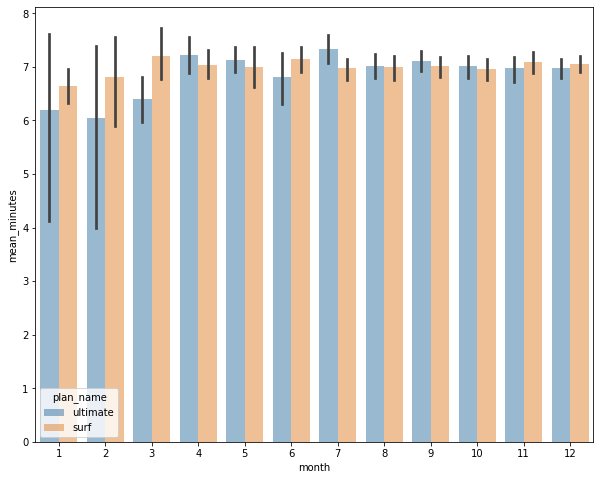

In [54]:
# Compara la duración promedio de llamadas por cada plan por cada mes. Dibuja una gráfica de barras para visualizarlo.
plt.subplots(figsize=(10,8))
sns.barplot(data=monthly_usage, x="month", y="mean_minutes",hue="plan_name",alpha=0.5)

Se observa que, ambos planes tienen casi la misma media de duracion de llamada en casi todos los meses, esto nos dice que las llamadas duran entre 6 a 8 minutos cada una en ambos planes.

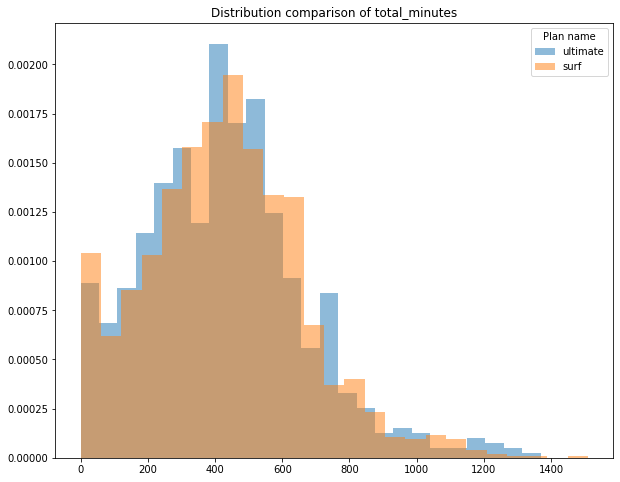

In [55]:
# Compara el número de minutos que los usuarios de cada plan requieren cada mes. Traza un histograma.

plt.figure(figsize=(10,8))
plt.hist(ultimate_monthly_usage['total_minutes'], bins=25, alpha=0.5, density=True, label='ultimate')
plt.hist(surf_monthly_usage['total_minutes'], bins=25, alpha=0.5, density=True, label='surf')
plt.title("Distribution comparison of total_minutes")
plt.legend(title="Plan name", loc='upper right')
plt.show()

Segun el grafico, se puede observar que los usuarios de ambos planes consumen en promedio mas de 400 minutos mensuales, en el caso de Surf, hay usuarios que llegan a consumir el triple de los 500 minutos disponibles en su paquete.

A continuacion, calculamos la media, mediana y varianza de la duración de la llamada para concluir si los usuarios de diferentes planes muestran comportamientos distintos para sus llamadas.

In [56]:
# Calcula la media y la varianza de la duración mensual de llamadas.

print('Plan Ultimate: \n', 
      '- Media:',ultimate_monthly_usage['total_minutes'].mean(), 
      '\n', '- Mediana:' ,ultimate_monthly_usage['total_minutes'].median(), 
      '\n', '- Varianza:' ,ultimate_monthly_usage['total_minutes'].var())
print('Plan Surf: \n', 
      '- Media:',surf_monthly_usage['total_minutes'].mean(), 
      '\n', '- Mediana:' ,surf_monthly_usage['total_minutes'].median(), 
      '\n', '- Varianza:' ,surf_monthly_usage['total_minutes'].var())

Plan Ultimate: 
 - Media: 430.45 
 - Mediana: 424.0 
 - Varianza: 57844.464812239225
Plan Surf: 
 - Media: 428.7495232040687 
 - Mediana: 425.0 
 - Varianza: 54968.27946065038


<AxesSubplot:xlabel='plan_name', ylabel='total_minutes'>

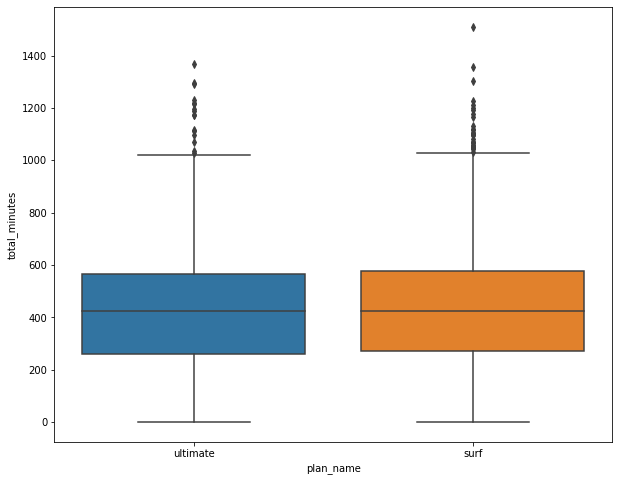

In [57]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
plt.subplots(figsize=(10,8))
sns.boxplot(data=monthly_usage, x='plan_name', y='total_minutes')

Segun el grafico, se puede observar que la distribucion de datos de ambos planes son parecidos. El plan Surf considera valores que incluso doblan el plan de minutos contratados mientras que, el plan Ultimate, llega hasta 1/3 del plan de los 3000 minutos contratado.

A partir de todos los graficos mostrados respecto al comportamiento del usuario, se obtiene que son muy pocos los usuarios con el plan 'ultimate' que siquiera consumen la mitad de los minutos disponibles en el plan, caso contrario con los usuarios del plan 'surf' que a pesar de solo tener disponible 500 minutos, alrededor del 50% supera el paquete de minutos ofrecidos.

### Mensajes

<AxesSubplot:xlabel='month', ylabel='total_messages'>

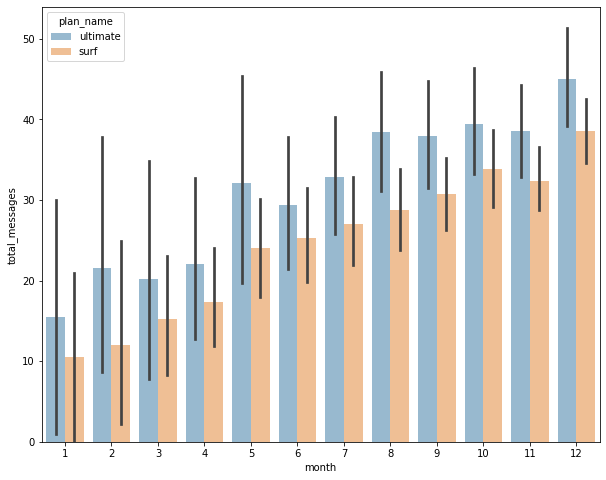

In [58]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
plt.subplots(figsize=(10,8))
sns.barplot(data=monthly_usage, x="month", y="total_messages",hue="plan_name",alpha=0.5)

A partir del grafico, se observa que los usuarios que utilizan el plan Ultimate, envian mas mensajes que los usuarios de Surf durante todo el año.

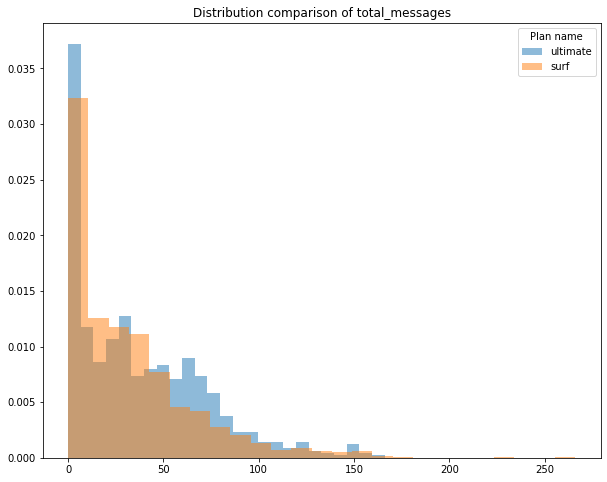

In [59]:
# Compara el número de mensajes que los usuarios de cada plan requieren cada mes. Traza un histograma.
plt.figure(figsize=(10,8))
plt.hist(ultimate_monthly_usage['total_messages'], bins=25, alpha=0.5, density=True, label='ultimate')
plt.hist(surf_monthly_usage['total_messages'], bins=25, alpha=0.5, density=True, label='surf')
plt.title("Distribution comparison of total_messages")
plt.legend(title="Plan name", loc='upper right')
plt.show()

En el histograma se puede ver que si bien la mayoria de usuarios de Surf hacen uso de su paquete de mensajes correspondiente, hay un porcentaje no tan minimo que supera en mas del doble del paquete. Para los usuarios de Ultimate y Surf, los picos mas altos se encuentran dentro de los 0 y 50 mensajes mensuales.

In [60]:
# Calcula la media y la varianza de la duración mensual de llamadas.

print('Plan Ultimate: \n', 
      '- Media:',ultimate_monthly_usage['total_messages'].mean(), 
      '\n', '- Mediana:' ,ultimate_monthly_usage['total_messages'].median(), 
      '\n', '- Varianza:' ,ultimate_monthly_usage['total_messages'].var())
print('Plan Surf: \n', 
      '- Media:',surf_monthly_usage['total_messages'].mean(), 
      '\n', '- Mediana:' ,surf_monthly_usage['total_messages'].median(), 
      '\n', '- Varianza:' ,surf_monthly_usage['total_messages'].var())

Plan Ultimate: 
 - Media: 37.55138888888889 
 - Mediana: 30.0 
 - Varianza: 1208.7567435481378
Plan Surf: 
 - Media: 31.15956770502225 
 - Mediana: 24.0 
 - Varianza: 1126.7245219504066


In [61]:
surf_monthly_usage['total_messages'].describe()

count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: total_messages, dtype: float64

In [62]:
ultimate_monthly_usage['total_messages'].describe()

count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: total_messages, dtype: float64

<AxesSubplot:xlabel='plan_name', ylabel='total_messages'>

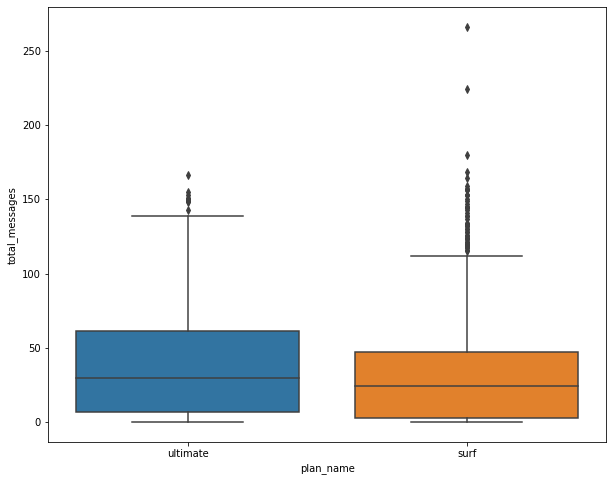

In [63]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
plt.subplots(figsize=(10,8))
sns.boxplot(data=monthly_usage, x='plan_name', y='total_messages')

En el diagrama de caja se puede observar que la mediana de surf es mas baja que la de ultimate, ademas, ambos planes presentan valores atipicos, siendo los de surf mas que los de ultimate. 

Asimismo, en el caso de Surf, se ve que el 25% de usuarios emiten mas de 47 mensajes mensualmente a pesar de contar con 50 mensajes disponibles en su plan y, en el caso de Ultimate, mas de 61 mensajes mensualmente sin sobrepasar su tope de 1000.


### Internet

<AxesSubplot:xlabel='month', ylabel='mb_used'>

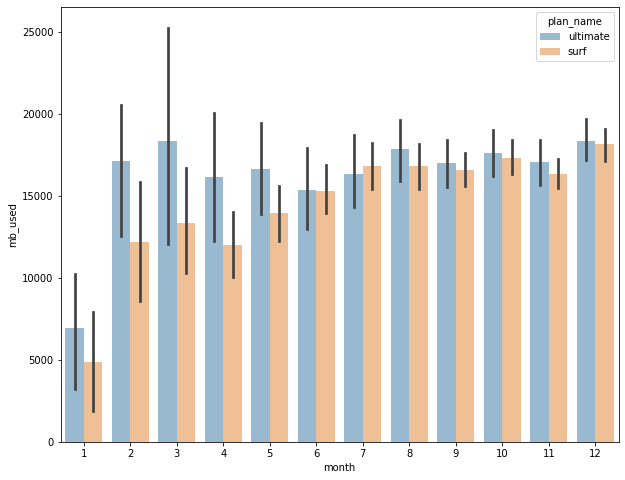

In [64]:
# Compara la cantidad de tráfico de internet consumido por usuarios por plan
# Compara la duración promedio de llamadas por cada plan por cada mes. Dibuja una gráfica de barras para visualizarlo.
plt.subplots(figsize=(10,8))
sns.barplot(data=monthly_usage, x="month", y="mb_used",hue="plan_name",alpha=0.5)

Segun el grafico mostrado, salvo por el mes de julio, los clientes de Ultimate tuvieron mayor trafico de internet en comparacion con los usuarios de Surf, en ambos casos la mayoria de usuarios utilizan entre los 12000 y 18000 mb en todo el año.

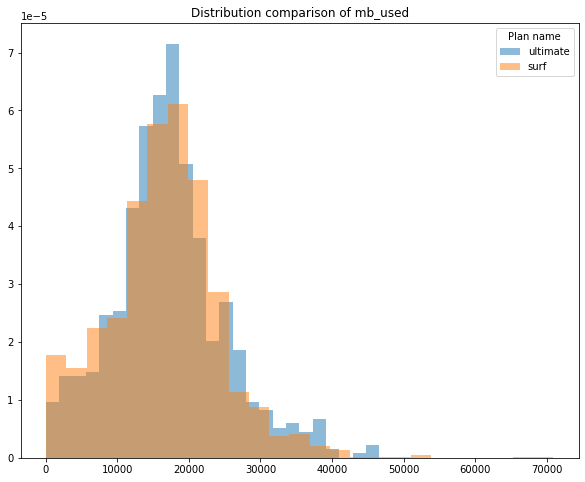

In [65]:
# Compara la cantidad de mb que los usuarios de cada plan requieren cada mes. Traza un histograma.
plt.figure(figsize=(10,8))
plt.hist(ultimate_monthly_usage['mb_used'], bins=25, alpha=0.5, density=True, label='ultimate')
plt.hist(surf_monthly_usage['mb_used'], bins=25, alpha=0.5, density=True, label='surf')
plt.title("Distribution comparison of mb_used")
plt.legend(title="Plan name", loc='upper right')
plt.show()

La mayoria de los usuarios de surf usaron cerca de 20000 mb excediendose en su plan de 15360 mb, mientras que los usuarios de ultimate, hicieron uso de entre 16000 y 18000 mb a pesar de tener disponible 30720 mb segun su plan.

<AxesSubplot:xlabel='plan_name', ylabel='mb_used'>

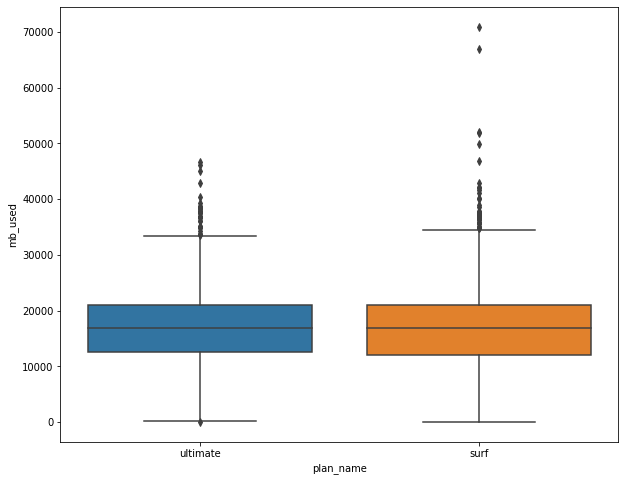

In [66]:
# Traza un diagrama de caja para visualizar la distribución de consumo total de internet.
plt.subplots(figsize=(10,8))
sns.boxplot(data=monthly_usage, x='plan_name', y='mb_used')

Las medianas de ambos planes son muy parecidas, ambas superan los 15000 mb. En el caso de Surf, tiene mas valores atipicos que Ultimate; ademas, los valores maximos de los 2 planes tambien son cercanos lo que se infiere que el paquete de mb que ofrece el plan de surf no es suficiente para sus usuarios.

## Ingreso

A continuacion, describiremos estadisticamente el ingreso de los usuarios.

<AxesSubplot:xlabel='month', ylabel='monthly_revenue'>

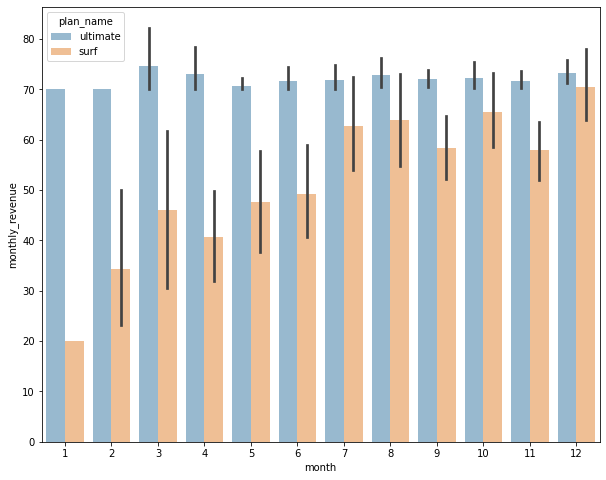

In [67]:
#Comparacion de que plan tiene mayores ingresos totales

ultimate_monthly_usage.head()

plt.subplots(figsize=(10,8))
sns.barplot(data=monthly_usage, x="month", y="monthly_revenue",hue="plan_name",alpha=0.5)

<AxesSubplot:xlabel='month'>

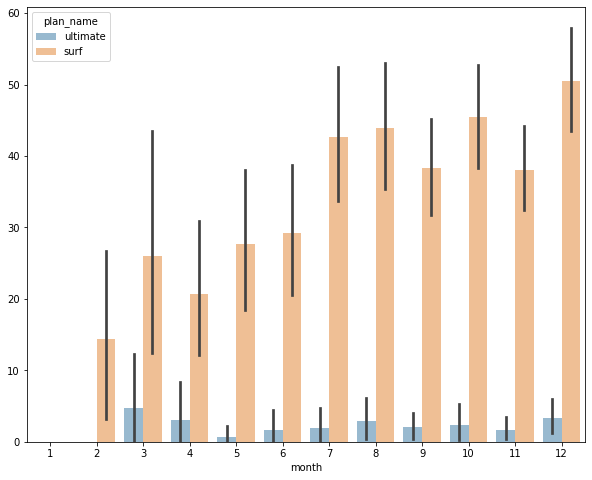

In [68]:
#Comparacion de que plan tiene mayores ingresos adicionales a sus planes
excess_revenue = monthly_usage['excess_minutes_revenue'] + monthly_usage['excess_messages_revenue']+monthly_usage['excess_gb_revenue']
plt.subplots(figsize=(10,8))
sns.barplot(data=monthly_usage, x="month", y=excess_revenue,hue="plan_name",alpha=0.5)

In [69]:
# Calcula la media y la varianza del ingreso mensual.

print('Plan Ultimate: \n', 
      '- Media:',ultimate_monthly_usage['monthly_revenue'].mean(), 
      '\n', '- Mediana:' ,ultimate_monthly_usage['monthly_revenue'].median(), 
      '\n', '- Varianza:' ,ultimate_monthly_usage['monthly_revenue'].var())
print('Plan Surf: \n', 
      '- Media:',surf_monthly_usage['monthly_revenue'].mean(), 
      '\n', '- Mediana:' ,surf_monthly_usage['monthly_revenue'].median(), 
      '\n', '- Varianza:' ,surf_monthly_usage['monthly_revenue'].var())

Plan Ultimate: 
 - Media: 72.31388888888888 
 - Mediana: 70.0 
 - Varianza: 129.8484855509195
Plan Surf: 
 - Media: 60.706408137317226 
 - Mediana: 40.36 
 - Varianza: 3067.835152293878


In [104]:
print('Plan Ultimate: \n',ultimate_monthly_usage['monthly_revenue'].describe())
print('Plan Surf: \n',surf_monthly_usage['monthly_revenue'].describe())

Plan Ultimate: 
 count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: monthly_revenue, dtype: float64
Plan Surf: 
 count    1573.000000
mean       60.706408
std        55.388042
min        20.000000
25%        20.000000
50%        40.360000
75%        80.360000
max       590.370000
Name: monthly_revenue, dtype: float64


array([<AxesSubplot:title={'center':'surf'}>,
       <AxesSubplot:title={'center':'ultimate'}>], dtype=object)

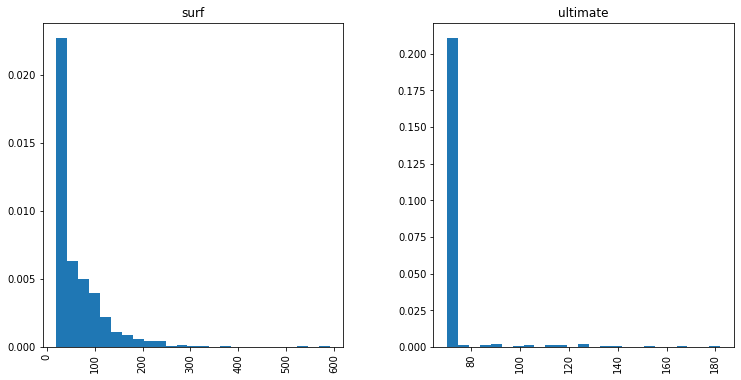

In [106]:
#Mostramos un histograma que muestra la frecuencia relativa del ingreso mensual en cada plan.
monthly_usage.hist(column ='monthly_revenue', by = 'plan_name' ,bins = 25, figsize = (12,6), density=True)

<AxesSubplot:xlabel='plan_name', ylabel='monthly_revenue'>

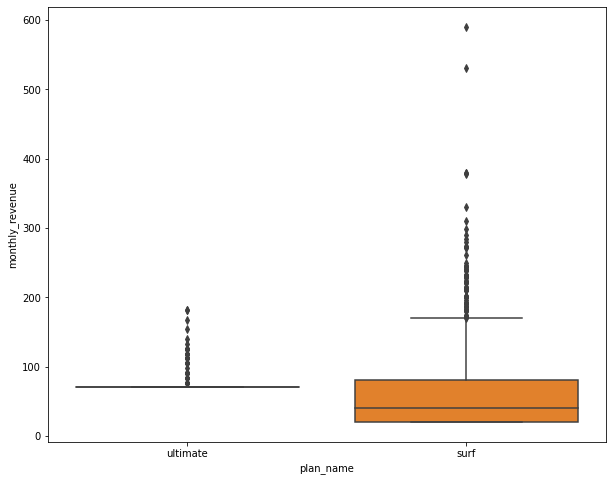

In [76]:
# Trazamos un diagrama de caja para visualizar la distribución de ingresos mensuales para cada plan.
plt.subplots(figsize=(10,8))
sns.boxplot(data=monthly_usage, x='plan_name', y='monthly_revenue')

A partir de los graficos respecto a los ingresos mensuales, se infiere que el plan Ultimate tiene mayores ingresos respecto a Surf, en el mes de diciembre, el plan de Surf casi iguala en ingresos a ultimate.
Sin embargo, es el plan de Surf el que supera enormemente en ingresos adicionales a su plan con respecto a Ultimate, mientras que el ingreso de Ultimate se mantiene constante en el costo de plan por defecto que es de 70$, esto se puede observar con el diagrama de cajas que muestra un mismo valor de ingreso mensual en toda su distribucion.

# Probar las hipótesis estadísticas.

## Hipotesis 1
Probamos las hipótesis de que es diferente el ingreso promedio de los usuarios de los planes de llamada Ultimate y Surf.

**Ho** = El ingreso promedio de los usuarios de los planes de llamada Ultimate y Surf no son diferentes.

**Ha** = El ingreso promedio de los usuarios de los planes de llamada Ultimate y Surf son diferentes.

**alpha** = 0.05

In [72]:
# Prueba las hipótesis
alpha = 0.05
results = st.ttest_ind(ultimate_monthly_usage['monthly_revenue'], surf_monthly_usage['monthly_revenue'])
print(results)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

Ttest_indResult(statistic=5.568949166552807, pvalue=2.862674510698644e-08)
p-value:  2.862674510698644e-08
Rechazamos la hipótesis nula


Segun los resultados de la comprobacion de la hipotesis, se rechaza la hipotesis nula de que el ingreso promedio de los usuarios de los planes de llamada Ultimate y Surf no son diferentes.

## Hipotesis 2
Probamos la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

**Ho** = El ingreso promedio de los usuarios del área NY-NJ no son diferentes de los usuarios de otras regiones.

**Ha** = El ingreso promedio de los usuarios del área NY-NJ son diferentes de los usuarios de otras regiones.

**alpha** = 0.05

In [73]:
#monthly_usage['city'].unique()

In [74]:
ny_nj_reg= monthly_usage.query('city =="New York-Newark-Jersey City, NY-NJ-PA MSA"')
other_reg= monthly_usage.query('city !="New York-Newark-Jersey City, NY-NJ-PA MSA"')

In [75]:
# Prueba las hipótesis
alpha = 0.05
results = st.ttest_ind(ny_nj_reg['monthly_revenue'], other_reg['monthly_revenue'])
print(results)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

Ttest_indResult(statistic=-2.0194429818968076, pvalue=0.04355743162134274)
p-value:  0.04355743162134274
Rechazamos la hipótesis nula


Segun los resultados de la comprobacion de la hipotesis, se rechaza la hipotesis nula de que el ingreso promedio de los usuarios del área NY-NJ no son diferentes de los usuarios de otras regiones.

# Conclusión general

1. En la preparacion de datos, tuvimos que comprender la informacion que nos ofrecia cada tabla y como estos valores se relacionaban con el objetivo que teniamos de saber cual de los planes genera mas ingresos, para ello corregimos algunos datos de manera que sean faciles de trabajar y analizar.
2. Luego de tener las tablas revisadas y limpias, agrupamos los datos de cada tabla por usuario y mes con el fin de unificarlos en un solo dataframe para tener la informacion relevante y completa en una sola vista. Esto nos ayudo a identificar que habian usuarios que se excedieron con los paquetes de minutos, mensajes e internet que los planes ofrecian mensualmente, lo que alteraria en el ingreso mensual de cada usuario en cada plan.
3. Seguidamente, estudiamos la distribucion estadistica del consumo de los usuarios y los ingresos. A partir de ello, se concluyo que el plan "Ultimate" tiene mayores ingresos que "Surf" unicamente porque su costo del plan es superior ya que, el plan de "Surf" es el que genera mayores ingresos por consumos adicionales a los disponibles contratados. Por lo tanto, se puede sugerir promover a que estos usuarios de "Surf" que exceden en sus consumos migren al plan "Ultimate" y asi crecer los ingresos de este plan.
4. Finalmente, se formularon 2 hipotesis de 2 colas comparando las medias de 2 poblaciones donde se rechazaron las hipotesis nulas aceptando las siguientes tesis: 
    - El ingreso promedio de los usuarios de los planes de llamada Ultimate y Surf son diferentes.
    - El ingreso promedio de los usuarios del área NY-NJ son diferentes de los usuarios de otras regiones.